In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D

from tensorflow.keras.models import load_model

2024-08-04 05:05:09.889481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 05:05:10.283691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 05:05:11.534901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-08-04 05:05:13.569600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 05:05:14.464723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 05:05:14.464948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
seed = 42
tf.random.set_seed(seed)

Found 19675 files belonging to 2 classes.


2024-08-04 05:05:15.942004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 05:05:15.942260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 05:05:15.942399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

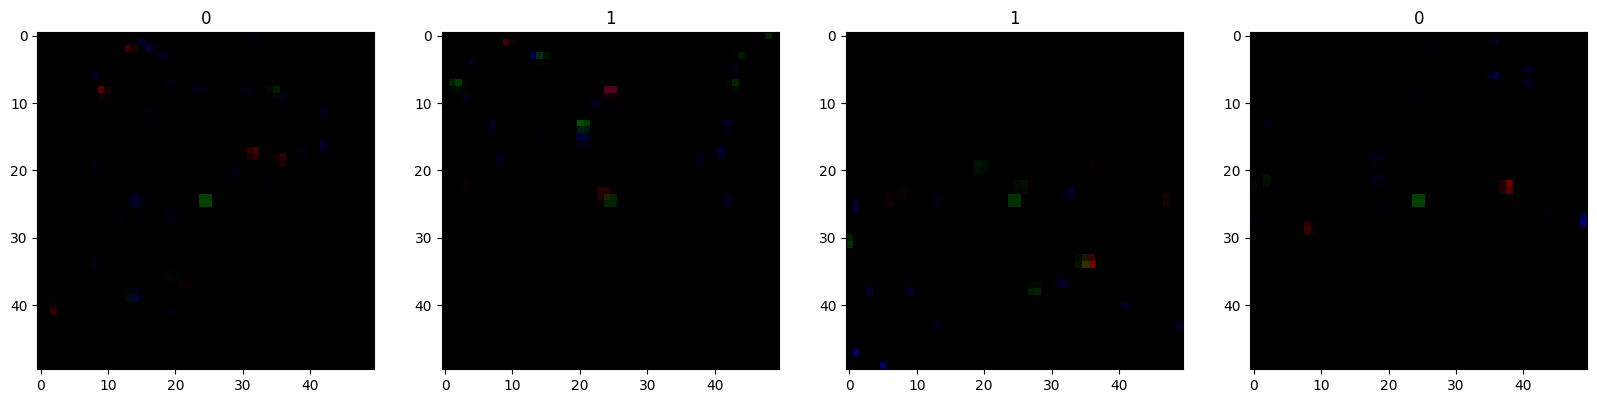

In [4]:
data_dir = 'EFlow Images/data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 200,
                                                   image_size = (50,50))

scaled_data = data.map(lambda x, y: (x/255, y))

data_iterator = scaled_data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [5]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [6]:
model4 = Sequential()

model4.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
model4.add(Conv2D(64, (3,3), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model4.add(Conv2D(64, (3,3), 1, activation='relu'))
model4.add(Conv2D(64, (3,3), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2)))

model4.add(Conv2D(32, (3,3), 1, activation='relu'))
model4.add(Conv2D(32, (3,3), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model4.add(Conv2D(16, (2,2), 1, activation='relu'))
model4.add(Conv2D(16, (2,2), 1, activation='relu'))
model4.add(AveragePooling2D(pool_size = (2,2)))

model4.add(Flatten())

model4.add(Dense(256, activation='relu'))
model4.add(Dense(512, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

In [7]:
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 47, 47, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 21, 21, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 17, 17, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 7, 7, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,249 (1.99 MB)

 Trainable params: 521,249 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model4.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [10]:
logdir = 'EFlow Images/logs5'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist4 = model4.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


I0000 00:00:1722748067.578672    2863 service.cc:145] XLA service 0x7fdd600065f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722748067.578903    2863 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-04 05:07:47.715810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-04 05:07:48.231858: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1722748084.254926    2863 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.5520 - auc: 0.5679 - false_negatives: 2175.3999 - false_positives: 917.1857 - loss: 0.6850 - precision: 0.5809 - recall: 0.4062 - true_negatives: 2653.2144 - true_positives: 1351.3429 - val_accuracy: 0.6297 - val_auc: 0.6694 - val_false_negatives: 743.0000 - val_false_positives: 664.0000 - val_loss: 0.6516 - val_precision: 0.6430 - val_recall: 0.6168 - val_true_negatives: 1197.0000 - val_true_positives: 1196.0000
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.6264 - auc: 0.6588 - false_negatives: 1810.5714 - false_positives: 833.3286 - loss: 0.6494 - precision: 0.6695 - recall: 0.4890 - true_negatives: 2745.7715 - true_positives: 1707.4714 - val_accuracy: 0.6647 - val_auc: 0.7256 - val_false_negatives: 773.0000 - val_false_positives: 501.0000 - val_loss: 0.6144 - val_precision: 0.7032 - val_recall: 0.6056 - val_true_negatives: 1339.0000 - val_true_positives: 1187.0000
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110

In [12]:
#model4.save(os.path.join('EFlow Images','Eflowimageclassifier4.keras'))

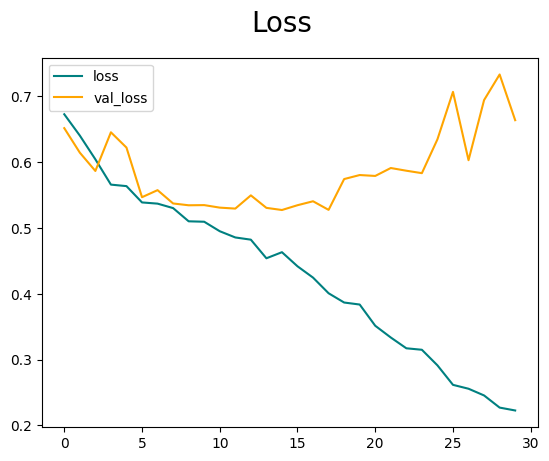

In [14]:
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

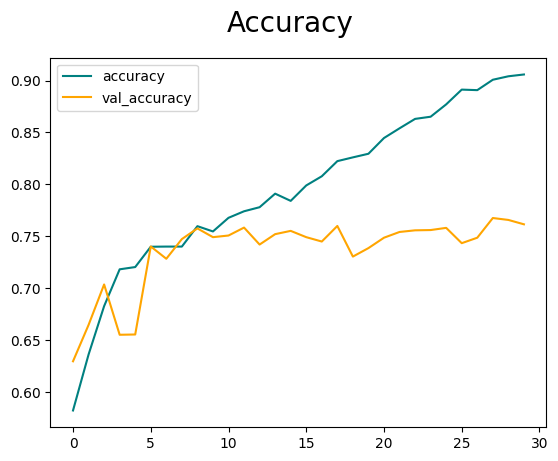

In [15]:
fig = plt.figure()
plt.plot(hist4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist4.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

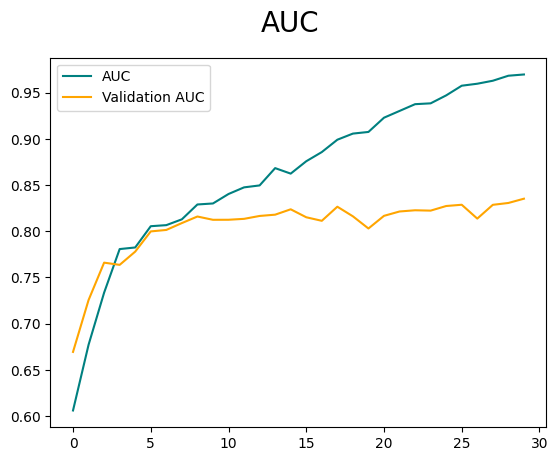

In [16]:
fig = plt.figure()
plt.plot(hist4.history['auc'], color='teal', label='AUC')
plt.plot(hist4.history['val_auc'], color='orange', label='Validation AUC')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [18]:
test_evaluate = model4.evaluate(test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7199 - auc: 0.7917 - false_negatives: 182.8000 - false_positives: 120.3000 - loss: 0.7885 - precision: 0.7539 - recall: 0.6629 - true_negatives: 415.4000 - true_positives: 361.5000
